
<div dir=ltr align=center>

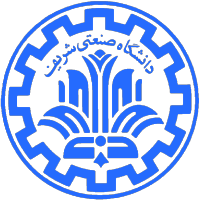

<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
Fall 2025 <br>
<font color=3C99D size=5>
    Clustering: Gaussian Mixture Model <br>
<font color=696880 size=4>
    Prepared by Benyamin Ghanbari <br>

<font color=696880 size=2>
    Curated by Alireza Mirshafieian

____

# Student Information

In [ ]:
student_number = '402171075'
full_name = 'Parsa Malekian'

# Customer Segmentation Using GMM

## Description:
In this project, you will implement a Gaussian Mixture Model (GMM) from scratch and use it to perform customer segmentation based on demographic and behavioral data. Customer segmentation is the process of grouping customers into clusters such that customers within the same cluster are more similar to each other than to those in other clusters. In this assignment, segmentation is done using a probabilistic clustering approach, where each customer is assigned a probability of belonging to each cluster based on features such as Age, Annual Income, and Spending Score.

**⚠️ Notice:** You are allowed to use only the imported libraries and must follow the provided function structure.

# 📝 **Project Instructions**

1. **Load the customer dataset**  
   Load the dataset containing customer information such as **Age, Annual Income, Spending Score**, and optionally **Gender**.

2. **Feature selection**  
    Anything that you need.

3. **Standardize features**  
   Normalize the numerical features using **standardization** so that each feature has **mean 0 and standard deviation 1**.

4. **Initialize GMM parameters**  
   Randomly initialize **cluster weights, means, and covariance matrices** for a chosen number of clusters **K**.

5. **Expectation-Maximization (EM) steps**  
   - **Expectation step:** Compute the **responsibility** of each cluster for every customer.  
   - **Maximization step:** Update **weights, means, and covariances** based on responsibilities.  
   - Repeat until **log-likelihood converges** or **max iterations** is reached.

6. **Multiple initializations**  
   Run the GMM algorithm **multiple times** with different random seeds and select the model with the **highest log-likelihood** to avoid poor local minima.

7. **Select the optimal number of clusters**  
   Compute **BIC (Bayesian Information Criterion)** for different values of **K** and choose the one with the **lowest BIC**.

8. **Assign clusters to customers**  
   For the final model, assign each customer to the cluster with the **highest responsibility**.

9. **Visualize clusters**  
   - **2D scatter plots:** Plot feature pairs (e.g., Age vs Income, Age vs Spending Score) with points colored by cluster.  
   - **Cluster centroids and circles:** Highlight **cluster centers** and **spread** using semi-transparent colored circles.  
   - **3D scatter plot:** Visualize clusters in 3D with **centroids marked**.



# 📤 **Expected Output**

- A **clustered customer dataset** showing each customer assigned to a **GMM cluster**  
- **2D scatter plots** of feature pairs (e.g., Age vs Income, Age vs Spending Score, Income vs Spending Score) with:  
  - Cluster points colored by cluster  
  - **Centroids** marked  
  - **Semi-transparent circles** showing cluster spread  
- A **3D scatter plot** visualizing all three features with cluster centroids highlighted  
- A **BIC vs. K plot** showing the Bayesian Information Criterion for different numbers of clusters, helping identify the **optimal K**  
- **Observe** which features distinguish clusters and how changing **K** affects segmentation quality


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle

In [3]:
# read data

df = pd.read_csv('Mall_Customers.csv')
df.head(10)

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [4]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

def standard_scale(X):
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_scaled = (X - means) / stds
    return X_scaled, means, stds

X_scaled, means_X, stds_X = standard_scale(X)



In [5]:
def gaussian_pdf_all(X, mean, cov):
    d = X.shape[1]

    # Add regularization to covariance matrix for numerical stability
    cov = cov + np.eye(d) * 1e-6

    # Compute normalization constant
    norm_const = -0.5 * (d * np.log(2 * np.pi) + np.log(np.linalg.det(cov)))

    # Compute exponent term
    diff = X - mean  # (n, d)
    cov_inv = np.linalg.inv(cov)
    exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)  # (n,)

    return np.exp(norm_const + exponent)

def initialize_parameters(X, k, rng):
    n, d = X.shape

    # Initialize weights uniformly
    weights = np.ones(k) / k

    # Initialize means by randomly selecting k data points
    indices = rng.choice(n, k, replace=False)
    means = X[indices].copy()

    # Initialize covariances as identity matrices scaled by data variance
    covs = []
    for _ in range(k):
        cov = np.eye(d) * np.var(X)
        covs.append(cov)

    return weights, means, covs

def expectation_step(X, weights, means, covs):
    n = X.shape[0]
    k = len(weights)

    # Compute weighted probabilities for each cluster
    resp = np.zeros((n, k))
    for j in range(k):
        resp[:, j] = weights[j] * gaussian_pdf_all(X, means[j], covs[j])

    # Normalize to get responsibilities
    resp_sum = np.sum(resp, axis=1, keepdims=True)
    resp = resp / (resp_sum + 1e-10)  # Add small value to avoid division by zero

    return resp

def maximization_step(X, resp):
    n, d = X.shape
    k = resp.shape[1]

    # Effective number of points assigned to each cluster
    Nk = np.sum(resp, axis=0)  # (k,)

    # Update weights
    weights = Nk / n

    # Update means
    means = []
    for j in range(k):
        mean = np.sum(resp[:, j:j+1] * X, axis=0) / (Nk[j] + 1e-10)
        means.append(mean)
    means = np.array(means)

    # Update covariances
    covs = []
    for j in range(k):
        diff = X - means[j]  # (n, d)
        cov = (resp[:, j:j+1] * diff).T @ diff / (Nk[j] + 1e-10)
        # Add regularization for numerical stability
        cov = cov + np.eye(d) * 1e-6
        covs.append(cov)

    return weights, means, covs

def compute_log_likelihood(X, weights, means, covs):
    n = X.shape[0]
    k = len(weights)

    # Compute weighted probabilities
    likelihood = np.zeros(n)
    for j in range(k):
        likelihood += weights[j] * gaussian_pdf_all(X, means[j], covs[j])

    # Compute log-likelihood
    ll = np.sum(np.log(likelihood + 1e-10))

    return ll

def gmm_train(X, k, max_iter=200, tol=1e-4, seed=None):
    rng = np.random.RandomState(seed)

    # Initialize parameters
    weights, means, covs = initialize_parameters(X, k, rng)

    # Initial log-likelihood
    ll = compute_log_likelihood(X, weights, means, covs)
    ll_history = [ll]

    # EM iterations
    for iteration in range(max_iter):
        # E-step
        resp = expectation_step(X, weights, means, covs)

        # M-step
        weights, means, covs = maximization_step(X, resp)

        # Compute new log-likelihood
        ll_new = compute_log_likelihood(X, weights, means, covs)
        ll_history.append(ll_new)

        # Check convergence
        if abs(ll_new - ll) < tol:
            print(f"Converged at iteration {iteration+1}")
            break

        ll = ll_new

    # Final responsibilities
    resp = expectation_step(X, weights, means, covs)

    return weights, means, covs, resp, ll

In [6]:
def compute_bic(ll, k, n, d):
    num_params = (k - 1) + k * d + k * d * (d + 1) / 2

    return -2 * ll + num_params * np.log(n)

bic_values = []
k_range = range(2, 9)
best_models = []
n, d = X_scaled.shape

print("Training GMM for different values of k...\n")

for k in k_range:
    print(f"Training for k={k}...")

    # Run multiple initializations to avoid poor local minima
    best_ll = -np.inf
    best_model = None

    for seed in range(10):
        weights, means, covs, resp, ll = gmm_train(X_scaled, k, max_iter=200, tol=1e-4, seed=seed)

        if ll > best_ll:
            best_ll = ll
            best_model = (weights, means, covs, resp, ll)

    best_models.append(best_model)

    bic = compute_bic(best_ll, k, n, d)
    bic_values.append(bic)

    print(f"  Best log-likelihood: {best_ll:.2f}")
    print(f"  BIC: {bic:.2f}\n")

best_k_idx = np.argmin(bic_values)
best_k = list(k_range)[best_k_idx]
print(f"\n{'='*50}")
print(f"Best k = {best_k} (BIC = {bic_values[best_k_idx]:.2f})")
print(f"{'='*50}")

best_weights, best_means, best_covs, best_resp, best_ll = best_models[best_k_idx]


Training GMM for different values of k...

Training for k=2...
Converged at iteration 39
Converged at iteration 44
Converged at iteration 31
Converged at iteration 42
Converged at iteration 41
Converged at iteration 30
Converged at iteration 31
Converged at iteration 42
Converged at iteration 24
Converged at iteration 44
  Best log-likelihood: -777.75
  BIC: 1656.16

Training for k=3...
Converged at iteration 92
Converged at iteration 39
Converged at iteration 42
Converged at iteration 66
Converged at iteration 24
Converged at iteration 81
Converged at iteration 32
Converged at iteration 42
Converged at iteration 28
Converged at iteration 41
  Best log-likelihood: -714.11
  BIC: 1581.87

Training for k=4...
Converged at iteration 130
Converged at iteration 65
Converged at iteration 18
Converged at iteration 35
Converged at iteration 87
Converged at iteration 36
Converged at iteration 25
Converged at iteration 51
Converged at iteration 38
Converged at iteration 42
  Best log-likelihood:

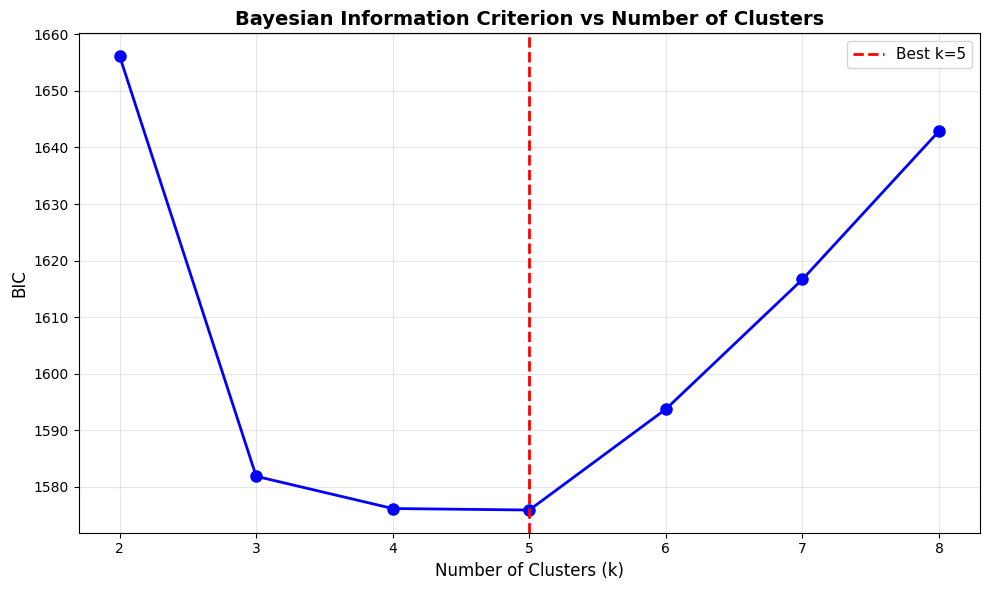

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, bic_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('BIC', fontsize=12)
plt.title('Bayesian Information Criterion vs Number of Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axvline(x=best_k, color='r', linestyle='--', linewidth=2, label=f'Best k={best_k}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()


In [8]:
cluster_labels = np.argmax(best_resp, axis=1)
df['Cluster'] = cluster_labels

print("Cluster assignments:")
print(df['Cluster'].value_counts().sort_index())
print("\nCluster statistics:")
for cluster_id in range(best_k):
    cluster_data = df[df['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"  Size: {len(cluster_data)}")
    print(f"  Age: {cluster_data['Age'].mean():.1f} ± {cluster_data['Age'].std():.1f}")
    print(f"  Income: {cluster_data['Annual Income (k$)'].mean():.1f} ± {cluster_data['Annual Income (k$)'].std():.1f}")
    print(f"  Spending: {cluster_data['Spending Score (1-100)'].mean():.1f} ± {cluster_data['Spending Score (1-100)'].std():.1f}")

Cluster assignments:
Cluster
0    56
1    23
2    30
3    52
4    39
Name: count, dtype: int64

Cluster statistics:

Cluster 0:
  Size: 56
  Age: 24.4 ± 4.9
  Income: 45.3 ± 19.0
  Spending: 58.2 ± 21.9

Cluster 1:
  Size: 23
  Age: 45.2 ± 13.2
  Income: 26.3 ± 7.9
  Spending: 20.9 ± 13.0

Cluster 2:
  Size: 30
  Age: 44.4 ± 8.4
  Income: 90.4 ± 16.7
  Spending: 17.9 ± 9.9

Cluster 3:
  Size: 52
  Age: 53.0 ± 10.5
  Income: 55.4 ± 8.2
  Spending: 49.2 ± 6.3

Cluster 4:
  Size: 39
  Age: 32.7 ± 3.7
  Income: 86.5 ± 16.3
  Spending: 82.1 ± 9.4


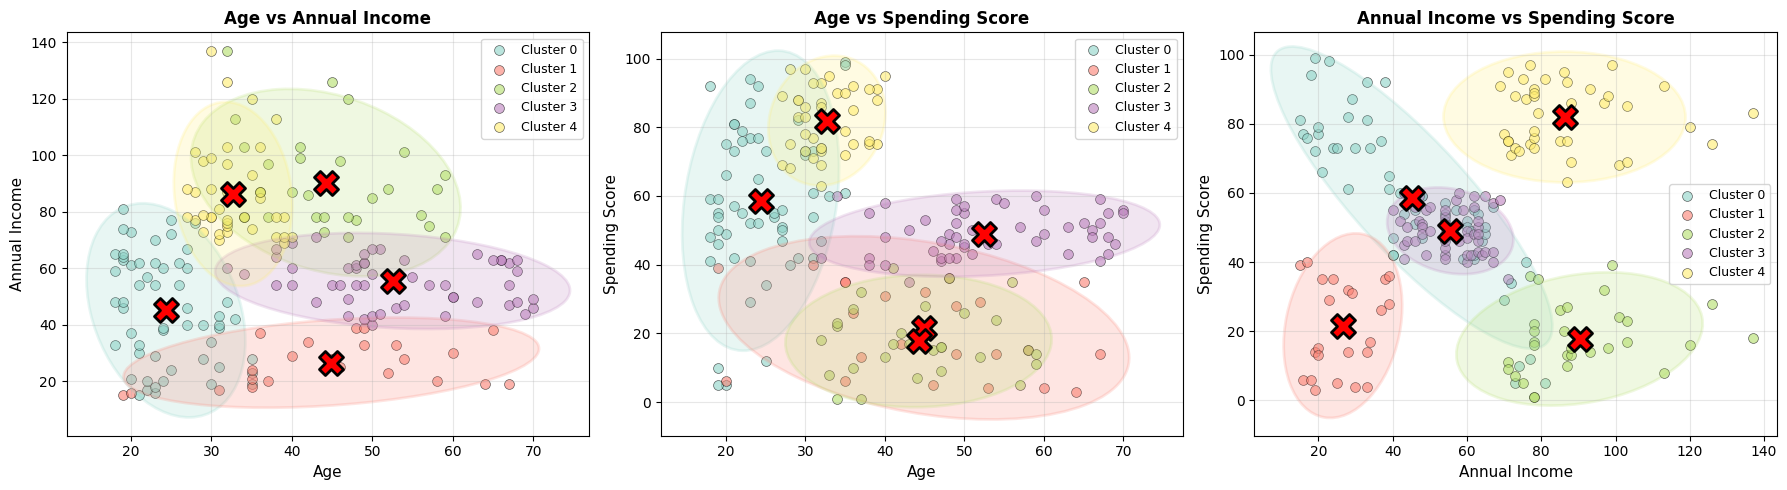

In [9]:
feature_names = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
feature_pairs = [(0, 1), (0, 2), (1, 2)]
pair_names = [('Age', 'Annual Income'), ('Age', 'Spending Score'), ('Annual Income', 'Spending Score')]

# Convert means back to original scale
best_means_original = best_means * stds_X + means_X

# Convert covariances back to original scale
best_covs_original = []
for cov in best_covs:
    cov_original = np.diag(stds_X) @ cov @ np.diag(stds_X)
    best_covs_original.append(cov_original)

colors = plt.cm.Set3(np.linspace(0, 1, best_k))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, ((i, j), (name_i, name_j)) in enumerate(zip(feature_pairs, pair_names)):
    ax = axes[idx]

    # Plot data points
    for cluster_id in range(best_k):
        cluster_data = X[cluster_labels == cluster_id]
        ax.scatter(cluster_data[:, i], cluster_data[:, j],
                  c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
                  alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

    # Plot centroids
    for cluster_id in range(best_k):
        ax.scatter(best_means_original[cluster_id, i], best_means_original[cluster_id, j],
                  c='red', marker='X', s=300, edgecolors='black', linewidth=2,
                  zorder=10)

        # Plot covariance ellipses
        cov_2d = best_covs_original[cluster_id][[i, j]][:, [i, j]]
        eigenvalues, eigenvectors = np.linalg.eig(cov_2d)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

        # 2 standard deviations (95% confidence)
        width, height = 2 * 2 * np.sqrt(eigenvalues)

        ellipse = plt.matplotlib.patches.Ellipse(
            (best_means_original[cluster_id, i], best_means_original[cluster_id, j]),
            width, height, angle=angle,
            facecolor=colors[cluster_id], alpha=0.2, edgecolor=colors[cluster_id],
            linewidth=2
        )
        ax.add_patch(ellipse)

    ax.set_xlabel(name_i, fontsize=11)
    ax.set_ylabel(name_j, fontsize=11)
    ax.set_title(f'{name_i} vs {name_j}', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

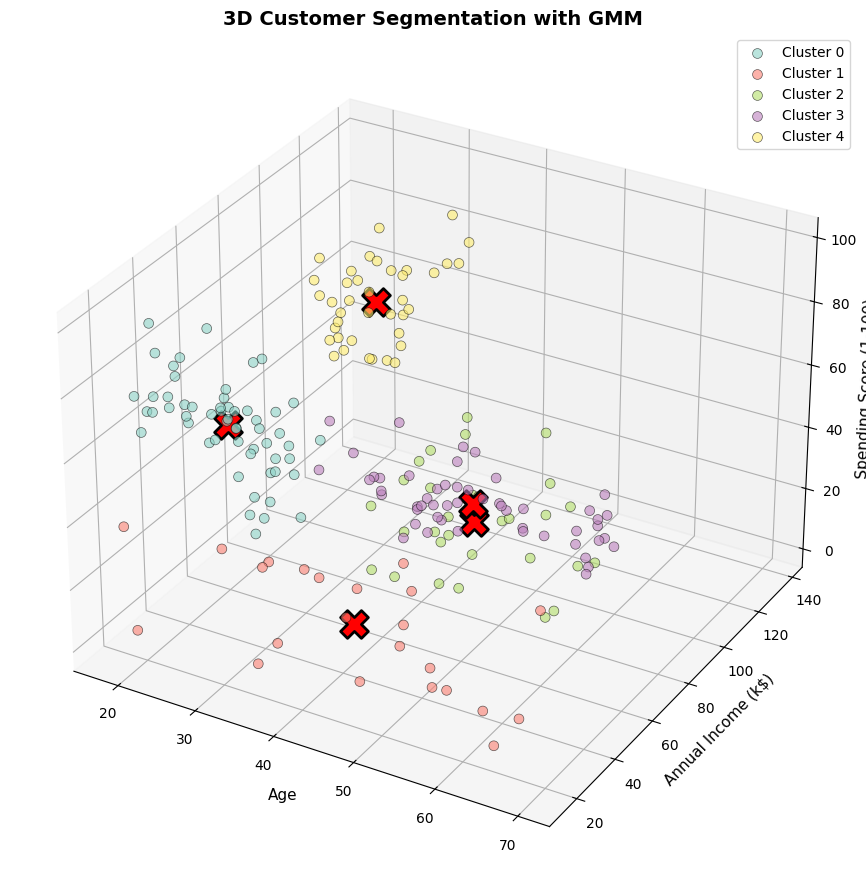

In [10]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot data points
for cluster_id in range(best_k):
    cluster_data = X[cluster_labels == cluster_id]
    ax.scatter(cluster_data[:, 0], cluster_data[:, 1], cluster_data[:, 2],
              c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
              alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Plot centroids
for cluster_id in range(best_k):
    ax.scatter(best_means_original[cluster_id, 0],
              best_means_original[cluster_id, 1],
              best_means_original[cluster_id, 2],
              c='red', marker='X', s=400, edgecolors='black', linewidth=2,
              zorder=10)

ax.set_xlabel('Age', fontsize=11)
ax.set_ylabel('Annual Income (k$)', fontsize=11)
ax.set_zlabel('Spending Score (1-100)', fontsize=11)
ax.set_title('3D Customer Segmentation with GMM', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()